# Predicting stock price moves with Logistic Regression

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [5]:
YEAR = 252

## Load Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

### Select Investment Universe

In [7]:
data = data[data.dollar_vol_rank<100]

### Create Model Data

In [10]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume'], axis=1)

## Logistic Regression

### Define cross-validation parameters

In [11]:
train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [12]:
target = f'target_{lookahead}d'

In [13]:
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

0    57182
1    48867
Name: label, dtype: int64

In [14]:
Cs = np.logspace(-5, 5, 11)

In [15]:
cols = ['C', 'date', 'auc', 'ic', 'pval']

### Run cross-validation

In [16]:
%%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]
       
        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05
	 14.1 | 010 |   6.76% |  53.82%
	 27.6 | 020 |   6.39% |  53.23%
	 34.4 | 030 |   7.06% |  53.63%
	 41.3 | 040 |   6.04% |  53.15%
	 48.1 | 050 |   6.14% |  53.27%
	 54.9 | 060 |   5.93% |  53.21%
	 61.7 | 070 |   6.18% |  53.35%
0.0001
	  6.7 | 010 |   6.60% |  53.82%
	 13.5 | 020 |   6.18% |  53.21%
	 20.3 | 030 |   6.85% |  53.61%
	 27.0 | 040 |   5.75% |  53.09%
	 33.7 | 050 |   5.84% |  53.21%
	 40.3 | 060 |   5.65% |  53.15%
	 47.1 | 070 |   5.89% |  53.29%
0.001
	  6.9 | 010 |   6.03% |  53.61%
	 13.8 | 020 |   5.66% |  53.09%
	 20.6 | 030 |   6.06% |  53.34%
	 27.5 | 040 |   5.03% |  52.81%
	 34.3 | 050 |   5.10% |  52.95%
	 41.1 | 060 |   4.94% |  52.87%
	 47.9 | 070 |   5.14% |  53.00%
0.01
	  7.8 | 010 |   5.48% |  53.48%
	 15.4 | 020 |   5.56% |  53.13%
	 23.1 | 030 |   5.79% |  53.29%
	 30.7 | 040 |   5.05% |  52.86%
	 38.3 | 050 |   5.03% |  52.93%
	 46.0 | 060 |   4.83% |  52.80%
	 53.7 | 070 |   4.98% |  52.91%
0.1
	  8.6 | 010 |   5.02% |  53.35%
	 17.0 | 020 | 

### Evaluate Results

In [17]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('data.h5', 'logistic/predictions')

In [18]:
log_scores = pd.read_hdf('data.h5', 'logistic/scores')

In [19]:
log_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 38.7 KB


In [20]:
log_scores.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.533539,0.025310,0.468915,0.517531,0.535411,0.548726,0.600517
0.00010,75.0,0.533140,0.024665,0.472769,0.518784,0.533578,0.550072,0.596646
0.00100,75.0,0.530464,0.023518,0.482393,0.517050,0.528490,0.546940,0.578374
0.01000,75.0,0.529541,0.022209,0.485781,0.514176,0.528314,0.546185,0.577644
0.10000,75.0,0.529109,0.022185,0.484358,0.515267,0.527199,0.544999,0.582393
1.00000,75.0,0.528899,0.022157,0.484293,0.515162,0.526918,0.544259,0.581855
10.00000,75.0,0.528880,0.022156,0.484326,0.515267,0.526874,0.544135,0.581697
100.00000,75.0,0.528870,0.022158,0.484334,0.515304,0.526892,0.544122,0.581672
1000.00000,75.0,0.528874,0.022154,0.484334,0.515257,0.526883,0.544163,0.581688


### Plot Validation Scores

In [21]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

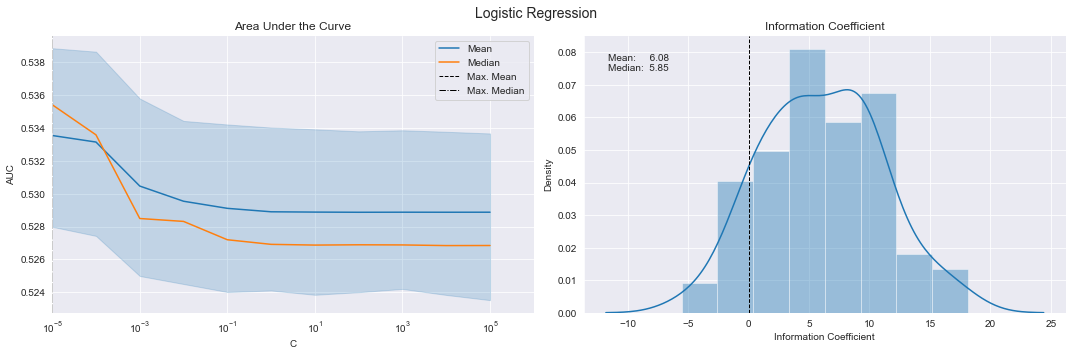

In [22]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);